In [9]:
#pip install pydicom
#pip install opencv-python
#pip install pypng

Processing c:\users\61424\appdata\local\pip\cache\wheels\3a\ad\91\4f6a5e9f3db79c28e71e7b59099dce8a75618a34ff415d44b1\pypng-0.0.20-py3-none-any.whlNote: you may need to restart the kernel to use updated packages.



In [10]:
%pylab inline
import cv2
import os
import numpy as np
import png
import PIL
import pydicom
import scipy
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [12]:
data_dir = '../P5/INbreast Release 1.0/AllDICOMs'
patients = os.listdir(data_dir)
labels_df = pd.read_excel('../P5/INbreast Release 1.0/INbreast.xlsx',index_col = 0)
labels_df.head()

,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Cancer
Patient ID,,,,,,,,
removed,removed,R,CC,201001,22678622,4,1,0
removed,removed,L,CC,201001,22678646,4,3,0
removed,removed,R,MLO,201001,22678670,4,1,0
removed,removed,L,MLO,201001,22678694,4,3,0
removed,removed,R,CC,201001,22614074,2,5,1


In [13]:
labels_df.dtypes

Patient age         object
Laterality          object
View                object
Acquisition date     int64
File Name            int64
ACR                 object
Bi-Rads             object
Cancer               int64
dtype: object

In [14]:
labels_df['Cancer'] = labels_df.Cancer.astype(object)
labels_df.head()

,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Cancer
Patient ID,,,,,,,,
removed,removed,R,CC,201001,22678622,4,1,0
removed,removed,L,CC,201001,22678646,4,3,0
removed,removed,R,MLO,201001,22678670,4,1,0
removed,removed,L,MLO,201001,22678694,4,3,0
removed,removed,R,CC,201001,22614074,2,5,1


In [15]:
import pydicom  as dicom
# make it True if you want in PNG format
PNG = True
# Specify the .dcm folder path
folder_path = '../P5/INbreast Release 1.0/AllDICOMs'
# Specify the output jpg/png folder path
jpg_folder_path = '../P5/INbreast Release 1.0/INbreast_png'
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == True:
        image = image.replace('.dcm', '.png')
    else:
        image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

0 image converted
50 image converted
100 image converted
150 image converted
200 image converted
250 image converted
300 image converted
350 image converted
400 image converted


InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

In [16]:
def gen_maxval_mask(dtype):
    '''Generate a maxval binary mask for a numpy uintX dtype
    '''
    if dtype not in [np.uint8, np.uint16, np.uint32, np.uint64]:
        raise Exception
    return np.array([-1]).astype(dtype)[0]

In [17]:
mammo_org = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png', 
                       cv2.IMREAD_GRAYSCALE)

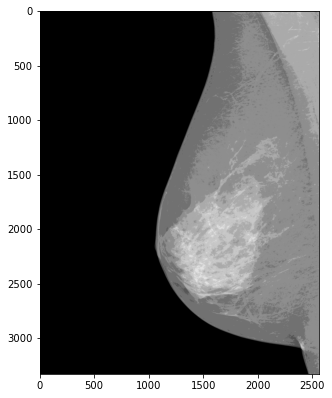

In [18]:
fig,ax = subplots()
fig.set_size_inches([5, 10])
ax.imshow(mammo_org, cmap='gray')

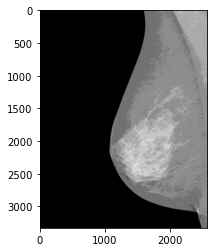

In [19]:
# This may be optional
def scale_image_01(mammo_org):
    return (255 - mammo_org.min()) / (mammo_org.max() - mammo_org.min())*mammo_org
mammo_scaled = scale_image_01(mammo_org)
ig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(mammo_scaled, cmap='gray')

### Median filtering 

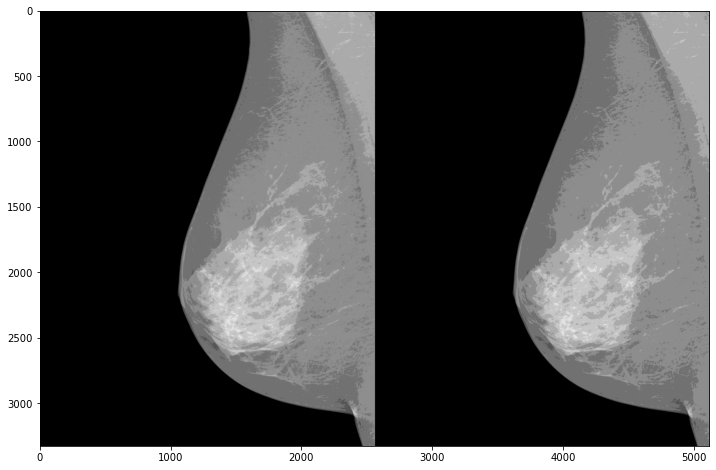

In [20]:
mammo_med_blurred = cv2.medianBlur(mammo_scaled.astype(np.uint8), 3)  # <<= para to tune!
fig,ax = subplots()
fig.set_size_inches([12, 9])
res = hstack((mammo_scaled, mammo_med_blurred))
plt.imshow(res, cmap='gray', vmin=0, vmax=255)
plt.show()

### Radiopaque artifacts suppresion

### Binarization

In [21]:
print(mammo_med_blurred)
print((mammo_med_blurred).max())

[[  0   0   0 ... 170 170 170]
 [  0   0   0 ... 170 170 170]
 [  0   0   0 ... 170 170 170]
 ...
 [  0   0   0 ... 113 113 141]
 [  0   0   0 ... 113 141 141]
 [  0   0   0 ... 141 113 113]]
226


In [22]:
def convert_scale_alpha(maxval):
    return 255.0/maxval

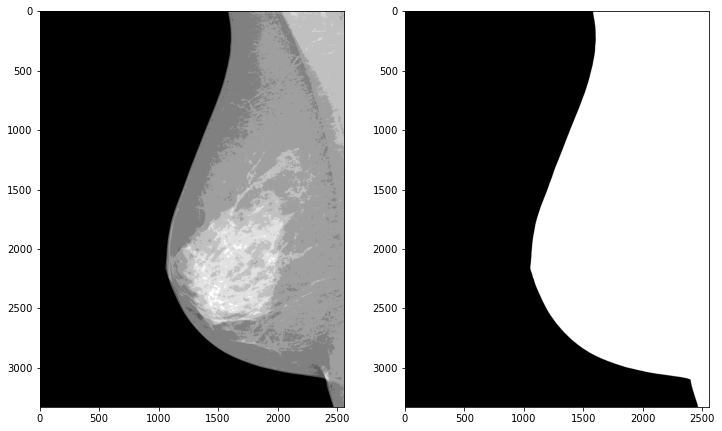

In [23]:
global_threshold = 18  # from Nagi thesis. <<= para to tune!
#mammo_med_blurred_col = cv2.cvtColor(mammo_med_blurred, cv2.COLOR_GRAY2BGR)
#mammo_med_blurred_u8 = cv2.convertScaleAbs(mammo_med_blurred, alpha=u16u8_alpha)
_, mammo_binary = cv2.threshold(mammo_med_blurred, global_threshold, 
                                maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_binary, cmap='gray')

### Artifacts Suppression

In [22]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin(2D array): 2D numpy array of binary image.
        lab_val([int]): integer value used for the label of the largest 
                        object. Default is 255.
        fill_holes([boolean]): whether fill the holes inside the largest 
                               object or not. Default is false.
        smooth_boundary([boolean]): whether smooth the boundary of the 
                                    largest object using morphological 
                                    opening or not. Default is false.
        kernel_size([int]): the size of the kernel used for morphological 
                            operation.
    '''
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_16U)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

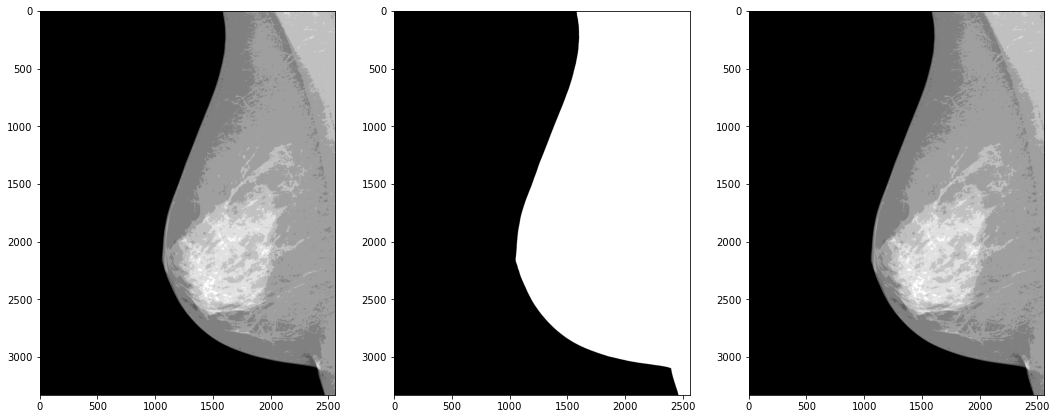

In [23]:
#u16_maxval = gen_maxval_mask(mammo_med_blurred.dtype)
mammo_breast_mask = select_largest_obj(mammo_binary.astype(np.uint8), lab_val=255, 
                                       fill_holes=True, 
                                       smooth_boundary=True, kernel_size=15)  # <<= para to tune!
mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr, cmap='gray')

## Pectoral Muscle Suppression

### Contrast Enhancement

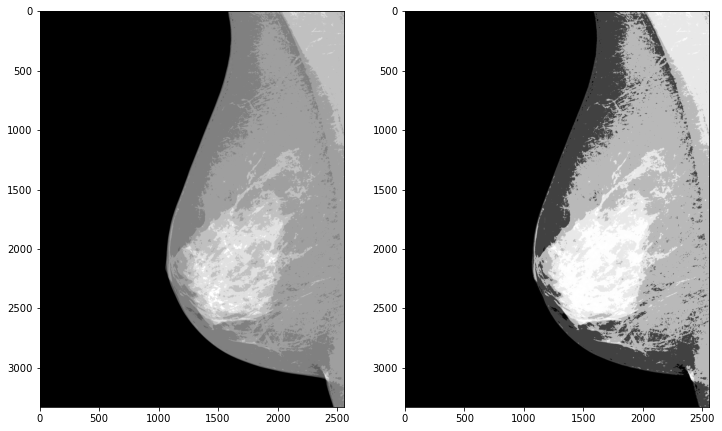

In [24]:
mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_arti_suppr, cmap='gray')
axes[1].imshow(mammo_breast_equ, cmap='gray')

### Watershed segmentation

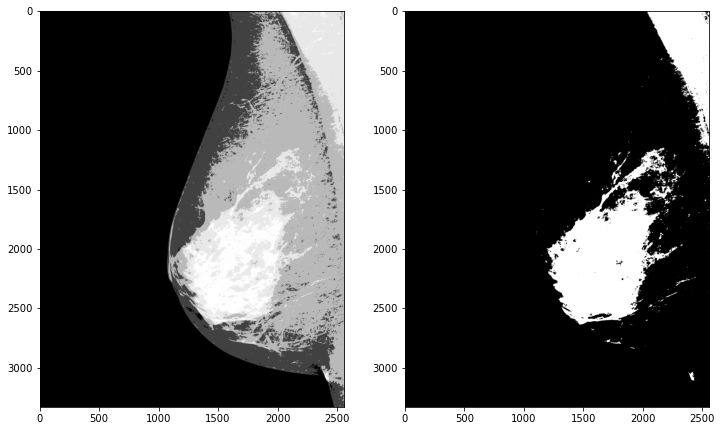

In [25]:
pect_high_inten_thres = 200  # <<= para to tune!
_, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres, 
                                     maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(pect_binary_thres, cmap='gray')

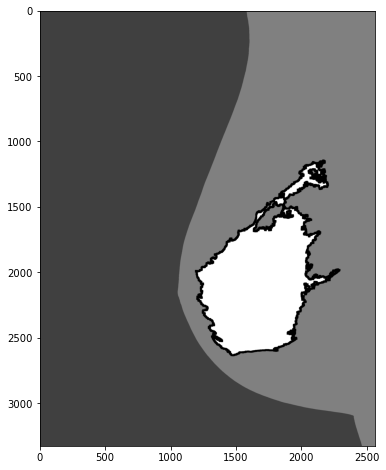

In [26]:
# Markers image for watershed algo.
pect_marker_img = np.zeros(pect_binary_thres.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(pect_binary_thres, lab_val=255, 
                                    fill_holes=True, smooth_boundary=False)
kernel_ = ones((3, 3), dtype=np.uint8)  # <<= para to tune!
n_erosions = 7  # <<= para to tune!
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7  # <<= para to tune!
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mammo_breast_mask == 0] = 64
# plot.
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(pect_marker_img, cmap='gray')

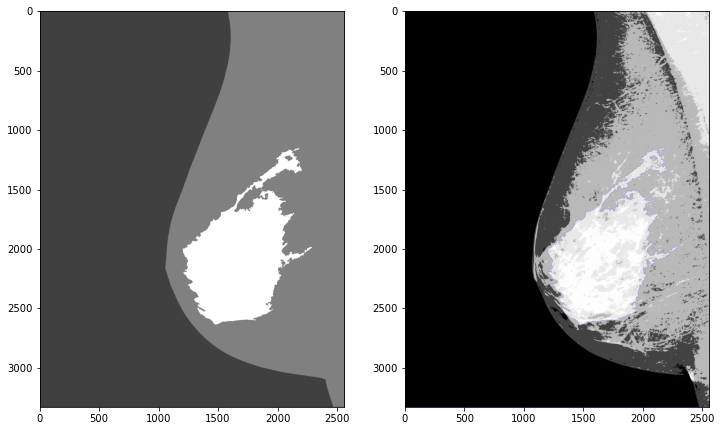

In [27]:
mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)

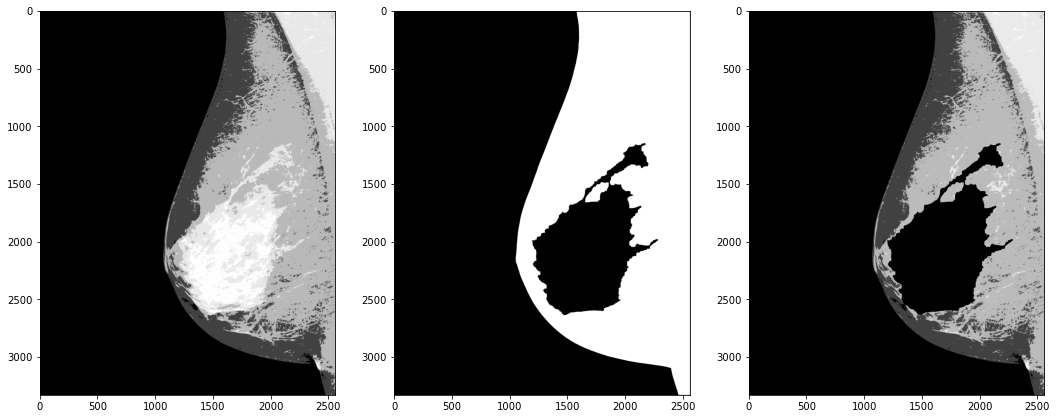

In [90]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')

## A pre-processing class

In [91]:
def gen_maxval_mask(dtype):
    '''Generate a maxval binary mask for a numpy uintX dtype
    '''
    if dtype not in [np.uint8, np.uint16, np.uint32, np.uint64]:
        raise Exception
    return np.array([-1]).astype(dtype)[0]

In [92]:
mammo_org = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png', 
                       cv2.IMREAD_GRAYSCALE)

In [93]:
from dm_preprocess import DMImagePreprocessor 
dm_img_pproc = DMImagePreprocessor()
mammo_pproc,mammo_col = dm_img_pproc.process(mammo_org)

Populating the interactive namespace from numpy and matplotlib


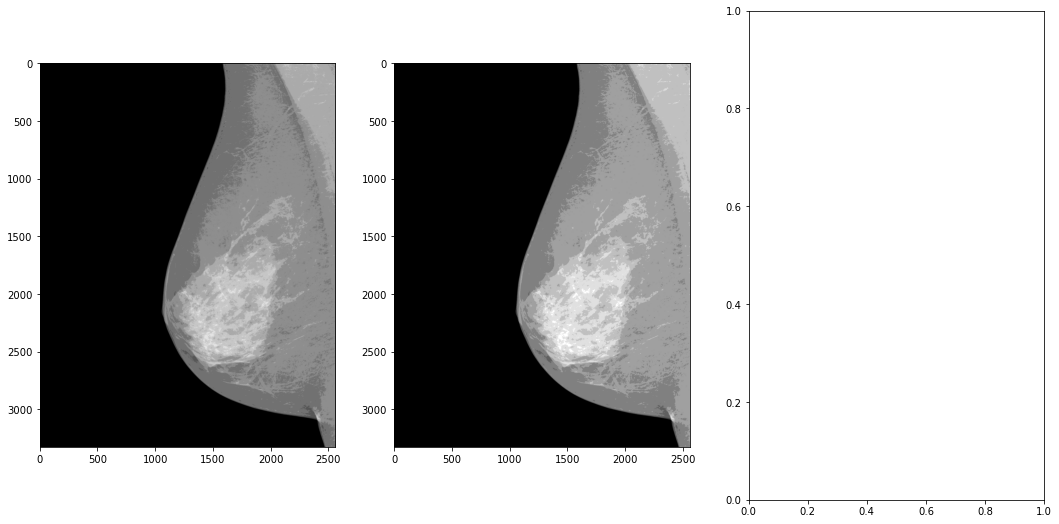

In [94]:
%pylab inline
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')
#axes[2].imshow(mammo_col)

In [95]:
mammo_artif_removed, breast_mask = dm_img_pproc.suppress_artifacts(mammo_org)

In [96]:
mammo_pectoral_removed, _ = dm_img_pproc.remove_pectoral(mammo_artif_removed, breast_mask)

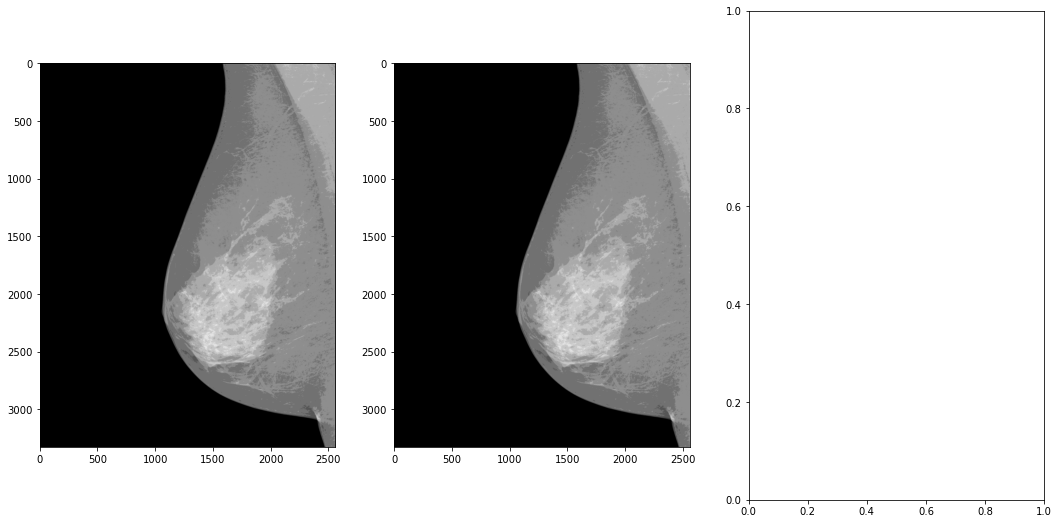

In [97]:
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_artif_removed, cmap='gray')
#axes[2].imshow(mammo_pectoral_removed, cmap='gray')

Populating the interactive namespace from numpy and matplotlib


C:\Users\61424\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


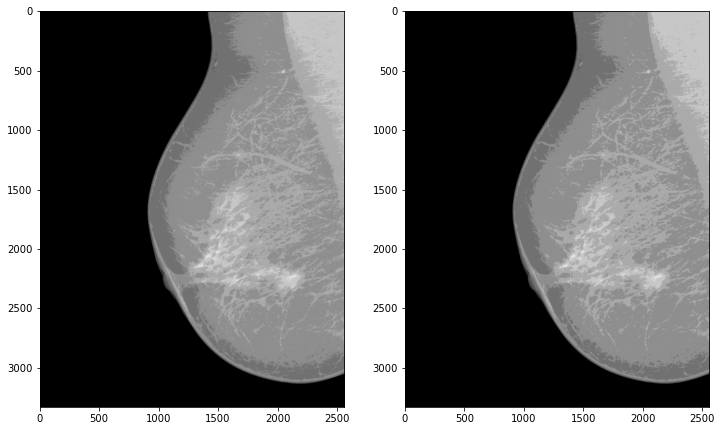

In [48]:
from dm_preprocess import DMImagePreprocessor
import cv2
%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_artif_breast = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/20588046_024ee3569b2605dc_MG_R_ML_ANON.png', 
                                cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_artif_breast, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_artif_breast, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

Populating the interactive namespace from numpy and matplotlib


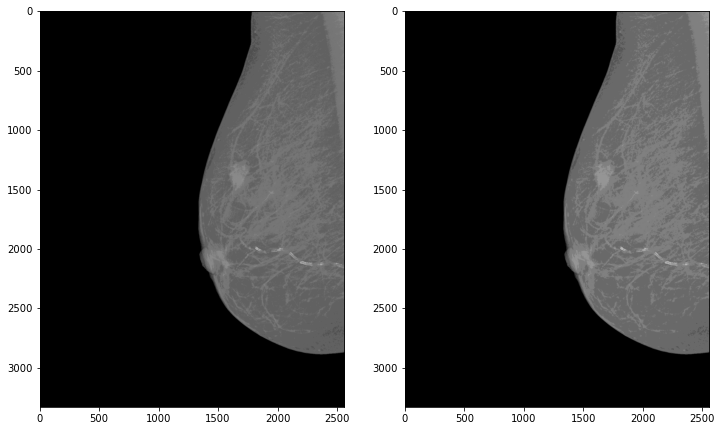

In [100]:
from dm_preprocess import DMImagePreprocessor
import cv2
%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_artif_breast = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/22670324_98429c0bdf78c0c7_MG_R_ML_ANON.png', 
                                cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_artif_breast, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_artif_breast, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

Populating the interactive namespace from numpy and matplotlib


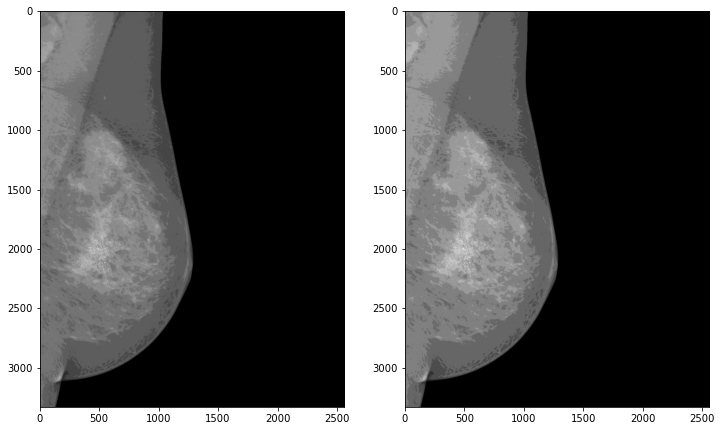

In [101]:
from dm_preprocess import DMImagePreprocessor
import cv2
%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_artif_breast = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/22670511_7e677f3d530e41ed_MG_L_ML_ANON.png', 
                                cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_artif_breast, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_artif_breast, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

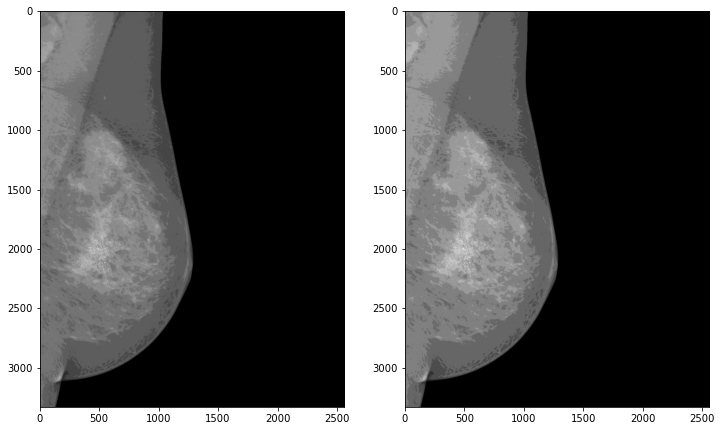

In [63]:
from dm_preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/22670511_7e677f3d530e41ed_MG_L_ML_ANON.png', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=False, high_int_threshold=50)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')


## Use finding contours for breast segmentation

In [73]:
img_norm = cv2.imread('../P5/INbreast Release 1.0/INbreast_png/20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png', cv2.IMREAD_UNCHANGED)
ret,th = cv2.threshold(img_norm.astype(np.uint8), 13, 255, cv2.THRESH_BINARY)

In [74]:
contours, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

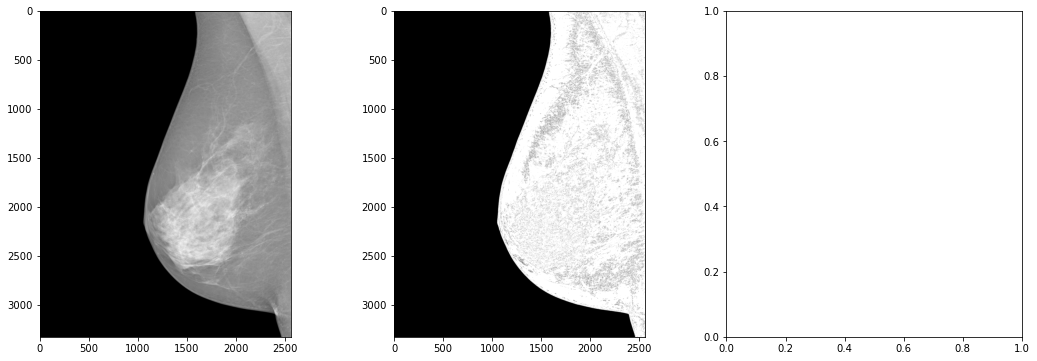

In [75]:
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 6])
axes[0].imshow(img_norm, cmap='gray')
axes[1].imshow(th, cmap='gray')
#axes[2].imshow(th_, cmap='gray')

In [76]:
cont_areas = [cv2.contourArea(c_) for c_ in contours]
np.argmax(cont_areas)

1

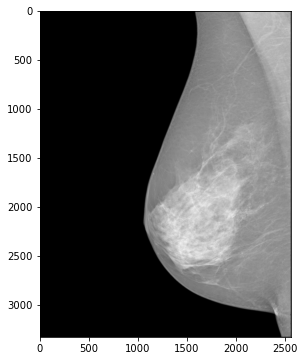

In [77]:
cont = cv2.drawContours(img_norm.copy(), contours, 1, (255,255,255), 3)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(cont, cmap='gray')

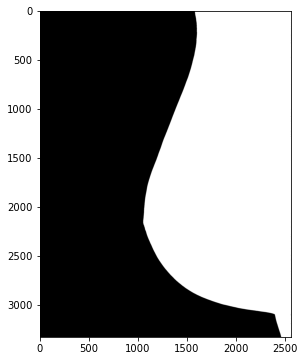

In [78]:
breast_mask = cv2.drawContours(np.zeros_like(th), contours, 1, 255, cv2.FILLED)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(breast_mask, cmap='gray')

In [79]:
cv2.boundingRect(contours[1])

(1052, 0, 1508, 3328)

In [72]:
from dm_preprocess import DMImagePreprocessor as prep
img = cv2.imread('20587080_b6a4f750c6df4f90_MG_R_ML_ANON.png', cv2.IMREAD_UNCHANGED)
img_breast = prep.segment_breast(img, .1)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

AttributeError: 'NoneType' object has no attribute 'astype'